In [ ]:
import os
from typing import List, Dict, TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
import json
import time
import re # Import regex for answer parsing

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# --- 1. Define the Agent State ---
class SocraticAgentState(TypedDict):
    """
    Represents the state of the Socratic tutoring agent.
    
    Attributes:
        messages: A list of BaseMessage objects representing the conversation history.
                  Annotated with add_messages to automatically append new messages.
        difficulty_level: The current difficulty level of the tutoring session (e.g., "beginner", "intermediate").
        user_struggle_count: An integer tracking how many times the user has struggled or answered incorrectly.
        topic: The main Python topic currently being discussed.
        sub_topic: A more specific sub-topic within the main topic.
        mcq_active: A boolean indicating if a Multiple Choice Question is currently active.
        mcq_question: The full text of the active MCQ, including options.
        mcq_options: A list of strings, each representing an option for the active MCQ.
        mcq_correct_answer: The correct answer (e.g., "A", "B", "C", "D") for the active MCQ.
        agent_thought: The internal thought process of the Socratic LLM before generating a response.
        next_node_decision: A string indicating the next node the router should transition to.
                            Used by the supervisor/router to control graph flow.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    agent_thought: str
    next_node_decision: str

# --- 2. Initialize the Socratic LLM and Tools ---

# Initialize the main Socratic LLM for general conversation and tool binding.
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

# Initialize a separate LLM for generating MCQs. This allows for different
# temperature or model settings specifically for MCQ generation.
mcq_generation_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.5)

# System prompt for the Socratic LLM, guiding its behavior and principles.
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your goal is to guide the user to discover answers
and understand concepts through thoughtful questions, rather than directly providing solutions.

Here are your core principles:
1.  **Ask Questions:** Always respond with a question, unless explicitly providing feedback on code or an MCQ answer.
2.  **Socratic Method:** Break down complex problems into smaller, manageable questions.
3.  **Encourage Exploration:** Prompt the user to experiment, research, or think critically.
4.  **Adapt to User Understanding:**
    * **Struggle Detection:** If the user seems confused, provides incorrect answers, or asks for direct solutions, simplify your questions, rephrase, or offer a hint. You can also suggest taking a multiple-choice question (MCQ) to assess their understanding differently.
    * **Progression:** If the user demonstrates understanding, subtly move to a slightly more advanced sub-concept or a related new topic. Avoid repetitive questioning on the same point.
5.  **Tool Usage:** You have access to several specialized tools. Use them judiciously based on the user's query:
    * `code_analysis_agent`: Use this when the user provides code and asks for feedback.
    * `code_explanation_agent`: Use this when the user asks for an explanation.
    * `challenge_generator_agent`: Use this when the user wants a coding challenge.
    * `mcq_agent`: Use this when you want to generate a multiple-choice question for **well-known or predefined topics** (like "variables", "functions", "classes"). This tool has pre-built questions.
    * `llm_mcq_generator`: Use this when the user asks for an MCQ on a topic that is **not explicitly covered by the `mcq_agent`'s predefined list**, or if you believe a more custom or nuanced question is needed based on the current discussion. This tool will ask the LLM to create a new MCQ.
    * `mcq_answer_processor`: Use this tool when the user submits an answer to an active MCQ. Provide the user's answer and the correct answer to this tool. This tool will handle updating the struggle count and resetting the MCQ state.
6.  **Maintain Context:** Keep track of the current topic and sub_topic.
7.  **Be Patient and Encouraging:** Foster a positive learning environment.
8.  **ReAct Architecture:** Before responding or calling a tool, always articulate your thought process. Start your response with "Thought: [Your reasoning here]". Then, proceed with your question or tool call. If you are calling a tool, the tool call should follow your thought. If you are directly asking a question, the question should follow your thought.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub_topic: {sub_topic}
User struggle count: {user_struggle_count}
MCQ active: {mcq_active}
MCQ Question (internal): {mcq_question} # Note: This is now the formatted string
MCQ Options (internal): {mcq_options}
MCQ Correct Answer (internal): {mcq_correct_answer}

Begin the conversation by asking the user what Python topic they'd like to learn or practice, or if they'd like to test their knowledge.
"""

# Chat prompt template for the Socratic LLM, including system prompt and message history.
socratic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", socratic_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# --- Define Tools ---
# These tools simulate external functionalities that the Socratic LLM can call.

@tool
def code_analysis_agent(code: str) -> str:
    """
    Analyzes the provided Python code.
    This is a simulated tool. In a real application, it would run static analysis, linters, etc.
    """
    return f"Simulated Code Analysis: Your code snippet '{code}' looks interesting. What were you trying to achieve with this code?"

@tool
def code_explanation_agent(concept: str) -> str:
    """
    Explains a given Python concept.
    This is a simulated tool. In a real application, it would provide detailed explanations.
    """
    return f"Simulated Code Explanation: Ah, you're curious about '{concept}'. Can you tell me what you already know or suspect about it?"

@tool
def challenge_generator_agent(topic: str, difficulty: str) -> str:
    """
    Generates a Python coding challenge based on a topic and difficulty level.
    This is a simulated tool. In a real application, it would generate a specific coding problem.
    """
    return f"Simulated Challenge for '{topic}': 'Write a function that sums even numbers in a list.' How would you start?"

@tool
def mcq_agent(topic: str, difficulty: str) -> str:
    """
    Generates a multiple-choice question (MCQ) on a given Python topic and difficulty level
    from a predefined list. The output will be a JSON string containing the question,
    options, and correct answer. The 'question' field will be pre-formatted to include
    options for direct display.
    This tool is called when the Socratic agent decides to test understanding via MCQ
    and a predefined question is available for the topic.
    """
    mcqs_raw = {
        "variables": {
            "question": "Which of the following data types is mutable in Python?",
            "options": ["A) Tuple", "B) String", "C) List", "D) Integer"],
            "correct_answer": "C"
        },
        "class": {
            "question": "In Python, what is the primary purpose of the `__init__` method in a class?",
            "options": [
                "A) To destroy an object when it's no longer needed.",
                "B) To define static methods.",
                "C) To initialize the attributes of an object when it's created.",
                "D) To define the string representation of an object."
            ],
            "correct_answer": "C"
        },
        "functions": {
            "question": "Which keyword is used to define a function in Python?",
            "options": ["A) func", "B) define", "C) def", "D) function"],
            "correct_answer": "C"
        },
        "conditional statements": {
            "question": "Which Python keyword is used to start an 'if' statement?",
            "options": ["A) then", "B) if", "C) when", "D) check"],
            "correct_answer": "B"
        },
        "comparisons": {
            "question": "What is the correct operator for 'not equal to' in Python?",
            "options": ["A) ==", "B) !=", "C) <>", "D) =!"],
            "correct_answer": "B"
        },
        "maximum of three numbers": {
            "question": "Consider finding the maximum of three numbers (a, b, c). Which of these logical structures is typically used?",
            "options": [
                "A) A single 'for' loop",
                "B) Nested 'if-else' statements or multiple 'if' statements with logical 'and'/'or'",
                "C) A 'while' loop",
                "D) A 'try-except' block"
            ],
            "correct_answer": "B"
        }
    }
    
    # Check if the exact topic exists in our predefined list (case-insensitive)
    selected_mcq_raw = mcqs_raw.get(topic.lower())

    if selected_mcq_raw:
        # Format the question to include options for direct display in chat
        formatted_question = f"**{selected_mcq_raw['question']}**\n\n" + \
                             "\n".join(selected_mcq_raw['options'])

        mcq_data = {
            "question": formatted_question,
            "options": selected_mcq_raw['options'],
            "correct_answer": selected_mcq_raw['correct_answer']
        }
        return json.dumps(mcq_data)
    else:
        # If topic not found, return a special string to indicate that the LLM should
        # consider using the `llm_mcq_generator` tool instead.
        return "NO_PREDEFINED_MCQ_FOUND"


@tool
def llm_mcq_generator(topic: str, difficulty: str) -> dict:
    """
    Generates an MCQ using an LLM based on a topic and difficulty level.
    """
    prompt = f"""
You are an expert Python tutor who generates multiple choice questions (MCQs) for practice.
Generate an MCQ on the topic "{topic}" at a "{difficulty}" level.

The MCQ must follow this format strictly as a JSON object:
{{
    "question": "string",
    "options": ["Option A", "Option B", "Option C", "Option D"],
    "answer_index": 1,
    "explanation": "string"
}}

For questions involving code snippets, format the code within triple backticks (```) to preserve readability, and ensure all strings are JSON-compatible (newlines escaped as \\n).
DO NOT include outer markdown code fences like ```json or ```python
Respond with raw valid JSON only. No extra text.
"""

    llm_response = llm.invoke([HumanMessage(content=prompt)])
    raw_llm_content = llm_response.content.strip()
    print("[DEBUG] Raw LLM MCQ Response:", repr(raw_llm_content))

    # Strip outer markdown fences
    cleaned_content = re.sub(r'^```(json|python)?\n?', '', raw_llm_content, flags=re.MULTILINE)
    cleaned_content = re.sub(r'\n?```$', '', cleaned_content, flags=re.MULTILINE)
    
    # Replace problematic characters, but preserve code formatting
    cleaned_content = (
        cleaned_content
        .replace('“', '"').replace('”', '"')  # Replace smart quotes
        .replace('‘', "'").replace('’', "'")  # Replace smart single quotes
        .replace('\u201c', '"').replace('\u201d', '"')  # Replace Unicode quotes
        .replace('\u2018', "'").replace('\u2019', "'")  # Replace Unicode single quotes
        .replace('\t', '    ')  # Replace tabs with spaces for code readability
    )

    print("[DEBUG] Cleaned LLM MCQ Response:", repr(cleaned_content))

    try:
        mcq_data = json.loads(cleaned_content)
        # Validate JSON structure
        required_keys = {"question", "options", "answer_index", "explanation"}
        if not all(key in mcq_data for key in required_keys):
            raise ValueError("Invalid MCQ format: Missing required keys")
        if not isinstance(mcq_data["options"], list) or len(mcq_data["options"]) != 4:
            raise ValueError("Invalid MCQ format: Options must be a list of 4 strings")
        if not isinstance(mcq_data["answer_index"], int) or mcq_data["answer_index"] not in [0, 1, 2, 3]:
            raise ValueError("Invalid MCQ format: answer_index must be an integer between 0 and 3")
        
        # Format question for display with options
        formatted_question = f"**{mcq_data['question']}**\n\n" + "\n".join(mcq_data["options"])
        mcq_data["question"] = formatted_question
        return mcq_data
    except (json.JSONDecodeError, ValueError) as e:
        print("[ERROR] JSON parsing or validation failed:", str(e))
        print("[ERROR] Cleaned content:", repr(cleaned_content))
        default_mcq = {
            "question": "**What is a Python decorator?**\n\n" + 
                        "\n".join([
                            "A) A function that modifies another function or method",
                            "B) A type of class inheritance",
                            "C) A syntax for defining variables",
                            "D) A loop construct"
                        ]),
            "options": [
                "A) A function that modifies another function or method",
                "B) A type of class inheritance",
                "C) A syntax for defining variables",
                "D) A loop construct"
            ],
            "answer_index": 0,
            "explanation": "A Python decorator is a function that wraps another function or method to extend or modify its behavior."
        }
        return {"error": f"Failed to parse or validate MCQ JSON: {str(e)}", **default_mcq}

@tool
def mcq_answer_processor(user_answer: str, correct_answer: str) -> str:
    """
    Processes the user's answer to an MCQ.
    Compares the user's answer with the correct answer and returns feedback.
    This tool is used by the `process_mcq_answer` node.
    """
    is_correct = user_answer.strip().upper() == correct_answer.strip().upper()
    if is_correct:
        return "Correct!"
    else:
        return "Incorrect."


# List of all tools available to the Socratic LLM
tools = [code_analysis_agent, code_explanation_agent, challenge_generator_agent, mcq_agent, llm_mcq_generator, mcq_answer_processor]
# Bind the tools to the main Socratic LLM, allowing it to call them.
llm_with_tools = llm.bind_tools(tools, tool_choice="auto")
# Combine the prompt and the LLM with tools into a runnable for the Socratic agent.
socratic_agent_runnable = socratic_prompt | llm_with_tools

# --- 3. Define the Graph Nodes ---

def call_llm(state: SocraticAgentState):
    """
    Invokes the Socratic LLM with the current conversation history and state.
    This node represents the core logic of the Socratic tutoring agent.
    It extracts the LLM's "thought" and formats the content for display.
    """
    print("[DEBUG] Entering call_llm node.")
    print("[DEBUG] Messages sent to LLM:", state["messages"])
    
    # Invoke the Socratic agent runnable with the current state.
    # Exclude 'messages' and 'next_node_decision' as they are handled separately by LangGraph/prompt.
    response = socratic_agent_runnable.invoke({
        "messages": state["messages"],
        **{k: v for k, v in state.items() if k not in ['messages', 'next_node_decision']}
    })
    print("[DEBUG] LLM Response:", response)
    
    thought = ""
    display_content = response.content # Initialize with the full content from LLM

    # Extract the internal "Thought:" from the LLM's response if present.
    if response.content and response.content.startswith("Thought:"):
        parts = response.content.split("Thought:", 1)
        thought_and_content = parts[1].strip()
        
        # The thought is typically the first line after "Thought:"
        thought_lines = thought_and_content.split('\n', 1)
        thought = thought_lines[0].strip()
        
        # The display content is the rest, if any
        if len(thought_lines) > 1:
            display_content = thought_lines[1].strip()
        else:
            display_content = "" # If only thought was present, hide it from user display

    # Create a new AIMessage to add to the state, preserving tool calls.
    new_ai_message = AIMessage(
        content=display_content,
        tool_calls=response.tool_calls
    )

    # Return the updated messages and the extracted thought.
    return {"messages": [new_ai_message], "agent_thought": thought}

# A dictionary mapping tool names to their corresponding Python functions.
TOOLS_USED = {
    "code_analysis_agent": code_analysis_agent,
    "code_explanation_agent": code_explanation_agent,
    "challenge_generator_agent": challenge_generator_agent,
    "mcq_agent": mcq_agent,
    "llm_mcq_generator": llm_mcq_generator,
    "mcq_answer_processor": mcq_answer_processor,
}

def call_tool(state: SocraticAgentState):
    """
    Executes a tool call requested by the Socratic LLM.
    Updates the state with the tool's output and relevant MCQ information if applicable.
    """
    print("[DEBUG] Entering call_tool node.")
    last_message = state["messages"][-1] # Get the last message, which should contain tool calls.
    
    messages_to_add = [] # List to accumulate new messages (e.g., ToolMessage)
    state_updates = {}   # Dictionary to accumulate state changes

    # Check if the last message is an AIMessage and contains tool calls.
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            tool_function = TOOLS_USED.get(tool_name) # Get the actual function for the tool.
            
            tool_output_content = ""
            if tool_function:
                response = tool_function.invoke(tool_args) # Invoke the tool.
                tool_output_content = str(response) # Convert tool response to string.

                # Special handling for MCQ generation tools (`mcq_agent`, `llm_mcq_generator`)
                if tool_name in ["mcq_agent", "llm_mcq_generator"]:
                    if tool_output_content == "NO_PREDEFINED_MCQ_FOUND":
                        # If mcq_agent couldn't find a predefined MCQ, add a ToolMessage
                        # and continue, allowing the LLM to potentially call llm_mcq_generator next.
                        messages_to_add.append(
                            ToolMessage(content="No predefined MCQ found for this topic.", tool_call_id=tool_call["id"])
                        )
                        continue # Skip to next tool call or finish this loop.
                    
                    try:
                        mcq_data = json.loads(tool_output_content) if isinstance(response, str) else response
                        # Check if the MCQ generation tool returned an error.
                        if "error" in mcq_data:
                            messages_to_add.append(
                                ToolMessage(content=f"Error generating MCQ: {mcq_data['error']}", tool_call_id=tool_call["id"])
                            )
                            continue # Skip if there was an error.

                        # Update state with MCQ details if generation was successful.
                        state_updates["mcq_active"] = True
                        state_updates["mcq_question"] = mcq_data.get("question", "")
                        state_updates["mcq_options"] = mcq_data.get("options", [])
                        state_updates["mcq_correct_answer"] = mcq_data.get("correct_answer", "")
                        # If a topic wasn't set yet in the state, set it from the tool arguments.
                        if not state.get("topic") and tool_args.get("topic"):
                            state_updates["topic"] = tool_args["topic"]
                    except json.JSONDecodeError:
                        # Handle cases where the tool's output is not valid JSON.
                        messages_to_add.append(
                            ToolMessage(content="Error: MCQ agent returned invalid JSON.", tool_call_id=tool_call["id"])
                        )
                        continue # Skip to next tool call or finish this loop.

                # Special handling for the `mcq_answer_processor` tool.
                elif tool_name == "mcq_answer_processor":
                    if tool_output_content == "Correct!":
                        state_updates["user_struggle_count"] = 0 # Reset struggle count on correct answer.
                    else:
                        # Increment struggle count on incorrect answer.
                        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
                    
                    # Reset MCQ state after processing an answer.
                    state_updates["mcq_active"] = False
                    state_updates["mcq_question"] = ""
                    state_updates["mcq_options"] = []
                    state_updates["mcq_correct_answer"] = ""
                
                # For all other tools, just append their output as a ToolMessage.
                messages_to_add.append(
                    ToolMessage(content=tool_output_content, tool_call_id=tool_call["id"])
                )

            else:
                # If a tool function is not found, add an error message.
                messages_to_add.append(
                    ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_call["id"])
                )
    print(f"[DEBUG] call_tool: State updates - {state_updates}")
    # Return the new messages and any state updates.
    return {"messages": messages_to_add, **state_updates}


def router(state: SocraticAgentState):
    """
    The supervisor node that decides the next action based on the current state and user input.
    It primarily routes between processing an MCQ answer directly or letting the Socratic LLM respond.
    
    Returns a dictionary containing 'next_node_decision' to control graph flow.
    """
    print("[DEBUG] Entering router node.")
    last_message = state["messages"][-1] # Get the latest message in the conversation.
    
    next_decision = ""
    # Check if an MCQ is active and the user's last message looks like an MCQ answer.
    if state.get("mcq_active", False) and isinstance(last_message, HumanMessage):
        user_input = last_message.content.strip().upper()
        # Use regex to robustly match typical MCQ answer formats (A, B, C, D, A., B), etc.
        if re.match(r"^[ABCD](\.|\))?$", user_input):
            print("[DEBUG] Router: Detected MCQ answer, routing to process_mcq_answer.")
            next_decision = "process_mcq_answer"
        else:
            print("[DEBUG] Router: MCQ active but no valid answer, routing to call_llm (Socratic Agent).")
            next_decision = "call_llm" # If MCQ active but answer is not valid, let LLM handle it
    else:
        print("[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).")
        next_decision = "call_llm"
    
    # Return a dictionary with the decision. LangGraph nodes must return a dict.
    return {"next_node_decision": next_decision}

def process_mcq_answer(state: SocraticAgentState):
    """
    Processes the user's MCQ answer by calling the mcq_answer_processor tool directly.
    This node is invoked by the `router` when an MCQ answer is detected.
    It updates the state based on the correctness of the answer and provides feedback.
    """
    print("[DEBUG] Entering process_mcq_answer node.")
    last_human_message = None
    # Find the most recent HumanMessage in the history.
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_human_message = msg
            break
    
    if not last_human_message:
        print("[ERROR] process_mcq_answer: Could not find a HumanMessage to process.")
        return {"messages": []} # If no human message, nothing to process.

    user_answer = last_human_message.content.strip().upper()
    correct_answer = state.get("mcq_correct_answer", "")

    # Directly call the `mcq_answer_processor` tool function.
    tool_output_content = mcq_answer_processor.invoke({"user_answer": user_answer, "correct_answer": correct_answer})
    
    state_updates = {}
    messages_to_add = []

    # Update struggle count based on the tool's output.
    if tool_output_content == "Correct!":
        state_updates["user_struggle_count"] = 0
    else:
        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
    
    # Reset all MCQ-related state variables as the MCQ has been answered.
    state_updates["mcq_active"] = False
    state_updates["mcq_question"] = ""
    state_updates["mcq_options"] = []
    state_updates["mcq_correct_answer"] = ""

    # Add a ToolMessage to the history to record the tool's execution.
    messages_to_add.append(
        ToolMessage(content=tool_output_content, tool_call_id="mcq_processor_direct_call") # Using a dummy ID for direct call.
    )
    # Add an AIMessage to provide immediate feedback to the user.
    messages_to_add.append(
        AIMessage(content=f"You answered: {user_answer}. The correct answer was {correct_answer}. {tool_output_content}")
    )

    print(f"[DEBUG] process_mcq_answer: Result - {tool_output_content}, New struggle count: {state_updates.get('user_struggle_count')}")
    
    # Return the new messages and any state updates.
    return {"messages": messages_to_add, **state_updates}


# --- 4. Define the Graph Edges ---

def should_continue_socratic(state: SocraticAgentState):
    """
    Determines if the Socratic LLM (after its `call_llm` node) needs to call a tool
    or if its turn is complete (i.e., it has generated a direct response).
    """
    print("[DEBUG] Entering should_continue_socratic edge logic.")
    # If the last message from the LLM contains tool calls, transition to `call_tool`.
    if isinstance(state["messages"][-1], AIMessage) and state["messages"][-1].tool_calls:
        print("[DEBUG] should_continue_socratic: Socratic agent has tool calls, routing to call_tool.")
        return "call_tool"
    # Otherwise, the LLM's turn is complete, and the graph can end for this iteration.
    print("[DEBUG] should_continue_socratic: Socratic agent's turn ends (no tool calls).")
    return END

# --- 5. Build the LangGraph ---

# Initialize the StateGraph with our defined state.
workflow = StateGraph(SocraticAgentState)

# Add all the nodes to the workflow.
workflow.add_node("router", router) # The new supervisor node.
workflow.add_node("call_llm", call_llm) # The Socratic agent's LLM logic.
workflow.add_node("call_tool", call_tool) # The tool execution logic.
workflow.add_node("process_mcq_answer", process_mcq_answer) # Node for direct MCQ answer processing.

# Set the `router` node as the starting point of the graph.
workflow.set_entry_point("router")

# Define conditional edges from the `router` node.
# The `router` function itself determines the next node based on the state.
workflow.add_conditional_edges(
    "router",
    lambda state: state["next_node_decision"], # Use the decision stored in state by the router function.
    {
        "call_llm": "call_llm",         # If router decides, go to the Socratic LLM.
        "process_mcq_answer": "process_mcq_answer" # If router detects MCQ answer, go to process it.
    }
)

# Define conditional edges from the `call_llm` node (Socratic agent's LLM).
# `should_continue_socratic` determines if a tool needs to be called or if the turn ends.
workflow.add_conditional_edges(
    "call_llm",
    should_continue_socratic,
    {"call_tool": "call_tool", END: END} # If tool calls, go to `call_tool`; otherwise, end.
)

# Define a regular edge from `call_tool` back to `call_llm`.
# After a tool is executed, the Socratic LLM needs to process the tool's output and generate a response.
workflow.add_edge("call_tool", "call_llm")

# Define a regular edge from `process_mcq_answer` back to `call_llm`.
# After an MCQ answer is processed, the Socratic LLM needs to provide feedback and potentially a new question.
workflow.add_edge("process_mcq_answer", "call_llm")

# Compile the workflow into a runnable graph.
socratic_graph = workflow.compile()

# Example test for the new LLM-generated MCQ
print("\n--- Testing LLM-generated MCQ for an unknown topic (decorators) ---")
llm_mcq_state = {
    "messages": [HumanMessage(content="Can you give me an MCQ on Python decorators?")],
    "difficulty_level": "intermediate",
    "user_struggle_count": 0,
    "topic": "", # Topic will be set by the tool if not provided by user
    "sub_topic": "",
    "mcq_active": False,
    "mcq_question": "",
    "mcq_options": [],
    "mcq_correct_answer": "",
    "agent_thought": "",
    "next_node_decision": "" # Initialize this for the router
}
result_llm_mcq = socratic_graph.invoke(llm_mcq_state)
import pprint
pprint.pprint(result_llm_mcq)


--- Testing LLM-generated MCQ for an unknown topic (decorators) ---
[DEBUG] Entering router node.
[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).
[DEBUG] Entering call_llm node.
[DEBUG] Messages sent to LLM: [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='a8e565cf-c1ed-4977-8989-760b78f97cfe')]
[DEBUG] LLM Response: content='' additional_kwargs={'function_call': {'name': 'llm_mcq_generator', 'arguments': '{"topic": "Python decorators", "difficulty": "intermediate"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--0fb0e40d-3e73-41a5-8652-4141a84de7e0-0' tool_calls=[{'name': 'llm_mcq_generator', 'args': {'topic': 'Python decorators', 'difficulty': 'intermediate'}, 'id': '7e61c2d9-05b3-4859-973a-d90c18da6fbb', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1188, 'outpu

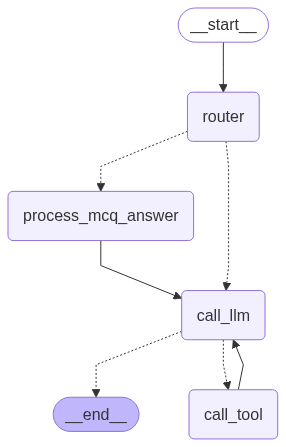


--- Testing LLM-generated MCQ for an unknown topic (decorators) ---
[DEBUG] Entering router node.
[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).
[DEBUG] Entering call_llm node.
[DEBUG] Messages sent to LLM: [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='5cca2d54-896d-4a78-abb0-8089f3360139')]
[DEBUG] LLM Response: content='' additional_kwargs={'function_call': {'name': 'mcq_agent', 'arguments': '{"topic": "Python decorators", "difficulty": "intermediate"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--44ef6222-2b3c-4e4a-bd41-507b75ea8720-0' tool_calls=[{'name': 'mcq_agent', 'args': {'topic': 'Python decorators', 'difficulty': 'intermediate'}, 'id': '04aca61f-8333-447c-91f4-0a32de1a12fd', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1267, 'output_tokens': 22, '

In [8]:
# --- Test ---
# This section provides example invocations to test the graph's behavior.
# It includes tests for LLM-generated MCQs, correct/incorrect MCQ answers,
# and regular conversation turns.

try:
    from IPython.display import Image, display
    # Attempt to draw and display the graph for visualization.
    display(Image(socratic_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not draw graph: {e}. This is often due to missing graphviz or pydot.")

# Example test for the new LLM-generated MCQ
print("\n--- Testing LLM-generated MCQ for an unknown topic (decorators) ---")
llm_mcq_state = {
    "messages": [HumanMessage(content="Can you give me an MCQ on Python decorators?")],
    "difficulty_level": "intermediate",
    "user_struggle_count": 0,
    "topic": "", # Topic will be set by the tool if not provided by user
    "sub_topic": "",
    "mcq_active": False,
    "mcq_question": "",
    "mcq_options": [],
    "mcq_correct_answer": "",
    "agent_thought": "",
    "next_node_decision": "" # Initialize this for the router
}
result_llm_mcq = socratic_graph.invoke(llm_mcq_state)
import pprint
pprint.pprint(result_llm_mcq)

# Test answering the MCQ (Correct Answer)
# print("\n--- Testing answering the MCQ (Correct Answer) ---")
# # Use the state from the previous step which now contains the active MCQ.
# mcq_answer_state_correct = result_llm_mcq 
# mcq_answer_state_correct["messages"].append(HumanMessage(content="B")) # User answers 'B'
# mcq_answer_state_correct["next_node_decision"] = "" # Reset for router to make a fresh decision
# result_mcq_answer_correct = socratic_graph.invoke(mcq_answer_state_correct)
# pprint.pprint(result_mcq_answer_correct)

# # Test answering the MCQ (Incorrect Answer)
# print("\n--- Testing answering the MCQ (Incorrect Answer) ---")
# # Reset state for a new MCQ test to ensure independence.
# llm_mcq_state_2 = {
#     "messages": [HumanMessage(content="Can you give me another MCQ, this time on Python generators?")],
#     "difficulty_level": "advanced",
#     "user_struggle_count": 0,
#     "topic": "",
#     "sub_topic": "",
#     "mcq_active": False,
#     "mcq_question": "",
#     "mcq_options": [],
#     "mcq_correct_answer": "",
#     "agent_thought": "",
#     "next_node_decision": ""
# }
# result_llm_mcq_2 = socratic_graph.invoke(llm_mcq_state_2)
# pprint.pprint(result_llm_mcq_2)

# mcq_answer_state_incorrect = result_llm_mcq_2 # Use the state from the previous step.
# mcq_answer_state_incorrect["messages"].append(HumanMessage(content="A")) # User answers 'A'
# mcq_answer_state_incorrect["next_node_decision"] = "" # Reset for router
# result_mcq_answer_incorrect = socratic_graph.invoke(mcq_answer_state_incorrect)
# pprint.pprint(result_mcq_answer_incorrect)

# print("\n--- Testing a regular conversation turn after MCQ ---")
# # Continue conversation after an MCQ has been answered.
# regular_turn_state = result_mcq_answer_incorrect # Use the state from the previous step.
# regular_turn_state["messages"].append(HumanMessage(content="Can you explain more about generators?"))
# regular_turn_state["next_node_decision"] = "" # Reset for router
# result_regular_turn = socratic_graph.invoke(regular_turn_state)
# pprint.pprint(result_regular_turn)

In [ ]:
import os
from typing import List, Dict, TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
import json
import re # Import regex for answer parsing
import time

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# --- 1. Define the Agent State ---
class SocraticAgentState(TypedDict):
    """
    Represents the state of the Socratic tutoring agent.
    
    Attributes:
        messages: A list of BaseMessage objects representing the conversation history.
                  Annotated with add_messages to automatically append new messages.
        difficulty_level: The current difficulty level of the tutoring session (e.g., "beginner", "intermediate").
        user_struggle_count: An integer tracking how many times the user has struggled or answered incorrectly.
        topic: The main Python topic currently being discussed.
        sub_topic: A more specific sub-topic within the main topic.
        mcq_active: A boolean indicating if a Multiple Choice Question is currently active.
        mcq_question: The full text of the active MCQ, including options.
        mcq_options: A list of strings, each representing an option for the active MCQ.
        mcq_correct_answer: The correct answer (e.g., "A", "B", "C", "D") for the active MCQ.
        mcq_explaination: The explaination for the mcq answer
        agent_thought: The internal thought process of the Socratic LLM before generating a response.
        next_node_decision: A string indicating the next node the router should transition to.
                            Used by the supervisor/router to control graph flow.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    mcq_explanation: str 
    agent_thought: str
    next_node_decision: str

# --- 2. Initialize the Socratic LLM and Tools ---

# Initialize the main Socratic LLM for general conversation and tool binding.
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", max_retries=3, temperature=0.7)

# Initialize a separate LLM for generating MCQs. This allows for different
# temperature or model settings specifically for MCQ generation.
mcq_generation_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", max_retries=3, temperature=0.5)

# System prompt for the Socratic LLM, guiding its behavior and principles.
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your goal is to guide the user to discover answers
and understand concepts through thoughtful questions, rather than directly providing solutions.

Here are your core principles:
1. **Ask Questions:** Always respond with a question, unless explicitly providing feedback on code or an MCQ answer.
2. **Socratic Method:** Break down complex problems into smaller, manageable questions.
3. **Encourage Exploration:** Prompt the user to experiment, research, or think critically.
4. **Adapt to User Understanding:**
    * **Struggle Detection:** If the user seems confused, provides incorrect answers, or asks for direct solutions, simplify your questions, rephrase, or offer a hint. You can also suggest taking a multiple-choice question (MCQ) to assess their understanding differently.
    * **Progression:** If the user demonstrates understanding, subtly move to a slightly more advanced sub-concept or a related new topic. Avoid repetitive questioning on the same point.
5. **Tool Usage:** You have access to several specialized tools. Use them judiciously based on the user's query:
    * `code_analysis_agent`: Use this when the user provides code and asks for feedback.
    * `code_explanation_agent`: Use this when the user asks for an explanation.
    * `challenge_generator_agent`: Use this when the user wants a coding challenge.
    * `mcq_agent`: Use this only for well-known topics like "variables", "functions", "classes", "conditional statements", "comparisons", or "maximum of three numbers".
    * `llm_mcq_generator`: Use this for all other topics (e.g., "Python decorators", "context managers") or when a custom MCQ is needed.
    * `mcq_answer_processor`: Use this when the user submits an answer to an active MCQ.
6. **Maintain Context:** Keep track of the current topic and sub_topic.
7. **Be Patient and Encouraging:** Foster a positive learning environment.
8. **ReAct Architecture:** Before responding or calling a tool, always articulate your thought process. Start your response with "Thought: [Your reasoning here]". Then, proceed with your question or tool call. If you are calling a tool, the tool call should follow your thought. If you are directly asking a question, the question should follow your thought.
9. **MCQ Answer Format:** When presenting an MCQ, instruct the user to respond with a single letter (A, B, C, or D) to indicate their answer choice.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub_topic: {sub_topic}
User struggle count: {user_struggle_count}
MCQ active: {mcq_active}
MCQ Question (internal): {mcq_question}
MCQ Options (internal): {mcq_options}
MCQ Correct Answer (internal): {mcq_correct_answer}

Begin the conversation by asking the user what Python topic they'd like to learn or practice, or if they'd like to test their knowledge.
"""

# Chat prompt template for the Socratic LLM, including system prompt and message history.
socratic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", socratic_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# --- Define Tools ---
# These tools simulate external functionalities that the Socratic LLM can call.

@tool
def code_analysis_agent(code: str) -> str:
    """
    Analyzes the provided Python code.
    This is a simulated tool. In a real application, it would run static analysis, linters, etc.
    """
    return f"Simulated Code Analysis: Your code snippet '{code}' looks interesting. What were you trying to achieve with this code?"

@tool
def code_explanation_agent(concept: str) -> str:
    """
    Explains a given Python concept.
    This is a simulated tool. In a real application, it would provide detailed explanations.
    """
    return f"Simulated Code Explanation: Ah, you're curious about '{concept}'. Can you tell me what you already know or suspect about it?"

@tool
def challenge_generator_agent(topic: str, difficulty: str) -> str:
    """
    Generates a Python coding challenge based on a topic and difficulty level.
    This is a simulated tool. In a real application, it would generate a specific coding problem.
    """
    return f"Simulated Challenge for '{topic}': 'Write a function that sums even numbers in a list.' How would you start?"

@tool
def mcq_agent(topic: str, difficulty: str) -> str:
    """
    Generates a multiple-choice question (MCQ) on a given Python topic and difficulty level
    from a predefined list. The output will be a JSON string containing the question,
    options, and correct answer. The 'question' field will be pre-formatted to include
    options for direct display.
    This tool is called when the Socratic agent decides to test understanding via MCQ
    and a predefined question is available for the topic.
    """
    mcqs_raw = {
        "variables": {
            "question": "Which of the following data types is mutable in Python?",
            "options": ["A) Tuple", "B) String", "C) List", "D) Integer"],
            "correct_answer": "C"
        },
        "class": {
            "question": "In Python, what is the primary purpose of the `__init__` method in a class?",
            "options": [
                "A) To destroy an object when it's no longer needed.",
                "B) To define static methods.",
                "C) To initialize the attributes of an object when it's created.",
                "D) To define the string representation of an object."
            ],
            "correct_answer": "C"
        },
        "functions": {
            "question": "Which keyword is used to define a function in Python?",
            "options": ["A) func", "B) define", "C) def", "D) function"],
            "correct_answer": "C"
        },
        "conditional statements": {
            "question": "Which Python keyword is used to start an 'if' statement?",
            "options": ["A) then", "B) if", "C) when", "D) check"],
            "correct_answer": "B"
        },
        "comparisons": {
            "question": "What is the correct operator for 'not equal to' in Python?",
            "options": ["A) ==", "B) !=", "C) <>", "D) =!"],
            "correct_answer": "B"
        },
        "maximum of three numbers": {
            "question": "Consider finding the maximum of three numbers (a, b, c). Which of these logical structures is typically used?",
            "options": [
                "A) A single 'for' loop",
                "B) Nested 'if-else' statements or multiple 'if' statements with logical 'and'/'or'",
                "C) A 'while' loop",
                "D) A 'try-except' block"
            ],
            "correct_answer": "B"
        }
    }
    
    # Check if the exact topic exists in our predefined list (case-insensitive)
    selected_mcq_raw = mcqs_raw.get(topic.lower())

    if selected_mcq_raw:
        # Format the question to include options for direct display in chat
        formatted_question = f"**{selected_mcq_raw['question']}**\n\n" + \
                             "\n".join(selected_mcq_raw['options'])

        mcq_data = {
            "question": formatted_question,
            "options": selected_mcq_raw['options'],
            "correct_answer": selected_mcq_raw['correct_answer']
        }
        return json.dumps(mcq_data)
    else:
        # If topic not found, return a special string to indicate that the LLM should
        # consider using the `llm_mcq_generator` tool instead.
        return "NO_PREDEFINED_MCQ_FOUND"


@tool
def llm_mcq_generator(topic: str, difficulty: str) -> dict:
    """
    Generates an MCQ using an LLM based on a topic and difficulty level.
    """
    prompt = f"""
You are an expert Python tutor who generates multiple choice questions (MCQs) for practice.
Generate an MCQ on the topic "{topic}" at a "{difficulty}" level.

The MCQ must follow this format strictly as a JSON object:
{{
    "question": "string",
    "options": ["Option A", "Option B", "Option C", "Option D"],
    "answer_index": 1,
    "explanation": "string"
}}

For questions involving code snippets, format the code within triple backticks (```) to preserve readability, and ensure all strings are JSON-compatible (newlines escaped as \\n).
DO NOT include outer markdown code fences like ```json or ```python
Respond with raw valid JSON only. No extra text.
"""

    llm_response = llm.invoke([HumanMessage(content=prompt)])
    raw_llm_content = llm_response.content.strip()
    print("[DEBUG] Raw LLM MCQ Response:", repr(raw_llm_content))

    # Strip outer markdown fences
    cleaned_content = re.sub(r'^```(json|python)?\n?', '', raw_llm_content, flags=re.MULTILINE)
    cleaned_content = re.sub(r'\n?```$', '', cleaned_content, flags=re.MULTILINE)
    
    # Replace problematic characters, but preserve code formatting
    cleaned_content = (
        cleaned_content
        .replace('“', '"').replace('”', '"')  # Replace smart quotes
        .replace('‘', "'").replace('’', "'")  # Replace smart single quotes
        .replace('\u201c', '"').replace('\u201d', '"')  # Replace Unicode quotes
        .replace('\u2018', "'").replace('\u2019', "'")  # Replace Unicode single quotes
        .replace('\t', '    ')  # Replace tabs with spaces for code readability
    )

    print("[DEBUG] Cleaned LLM MCQ Response:", repr(cleaned_content))

    try:
        mcq_data = json.loads(cleaned_content)
        # Validate JSON structure
        required_keys = {"question", "options", "answer_index", "explanation"}
        if not all(key in mcq_data for key in required_keys):
            raise ValueError("Invalid MCQ format: Missing required keys")
        if not isinstance(mcq_data["options"], list) or len(mcq_data["options"]) != 4:
            raise ValueError("Invalid MCQ format: Options must be a list of 4 strings")
        if not isinstance(mcq_data["answer_index"], int) or mcq_data["answer_index"] not in [0, 1, 2, 3]:
            raise ValueError("Invalid MCQ format: answer_index must be an integer between 0 and 3")
        
        # Format question for display with options
        formatted_question = f"**{mcq_data['question']}**\n\n" + "\n".join(mcq_data["options"])
        mcq_data["question"] = formatted_question
        return mcq_data
    except (json.JSONDecodeError, ValueError) as e:
        print("[ERROR] JSON parsing or validation failed:", str(e))
        print("[ERROR] Cleaned content:", repr(cleaned_content))
        default_mcq = {
            "question": "**What is a Python decorator?**\n\n" + 
                        "\n".join([
                            "A) A function that modifies another function or method",
                            "B) A type of class inheritance",
                            "C) A syntax for defining variables",
                            "D) A loop construct"
                        ]),
            "options": [
                "A) A function that modifies another function or method",
                "B) A type of class inheritance",
                "C) A syntax for defining variables",
                "D) A loop construct"
            ],
            "answer_index": 0,
            "explanation": "A Python decorator is a function that wraps another function or method to extend or modify its behavior."
        }
        return {"error": f"Failed to parse or validate MCQ JSON: {str(e)}", **default_mcq}

@tool
def mcq_answer_processor(user_answer: str, correct_answer: str, explanation: str = "") -> str:
    """
    Processes the user's answer to an MCQ.
    Compares the user's answer with the correct answer and returns feedback with explanation.
    """
    is_correct = user_answer.strip().upper() == correct_answer.strip().upper()
    if is_correct:
        return f"Correct!\n\nExplanation: {explanation}"
    else:
        return f"Incorrect.\n\nExplanation: {explanation}"


# List of all tools available to the Socratic LLM
tools = [code_analysis_agent, code_explanation_agent, challenge_generator_agent, mcq_agent, llm_mcq_generator, mcq_answer_processor]
# Bind the tools to the main Socratic LLM, allowing it to call them.
llm_with_tools = llm.bind_tools(tools, tool_choice="auto")
# Combine the prompt and the LLM with tools into a runnable for the Socratic agent.
socratic_agent_runnable = socratic_prompt | llm_with_tools

# --- 3. Define the Graph Nodes ---

def call_llm(state: SocraticAgentState):
    """
    Invokes the Socratic LLM with the current conversation history and state.
    This node represents the core logic of the Socratic tutoring agent.
    It extracts the LLM's "thought" and formats the content for display.
    """
    print("[DEBUG] Entering call_llm node.")
    print("[DEBUG] Messages sent to LLM:", state["messages"])
    
    max_attempts = 3
    for attempt in range(max_attempts):
        try:
            response = socratic_agent_runnable.invoke({
                "messages": state["messages"],
                **{k: v for k, v in state.items() if k not in ['messages', 'next_node_decision']}
            })
            print("[DEBUG] LLM Response:", response)
            
            content = response.content
            if isinstance(content, list):
                content = "\n".join(str(item) for item in content)
            elif not isinstance(content, str):
                print("[ERROR] Unexpected content type:", type(content))
                content = ""

            thought = ""
            display_content = ""
            if content and content.startswith("Thought:"):
                parts = content.split("Thought:", 1)
                thought_and_content = parts[1].strip()
                thought_lines = thought_and_content.split('\n', 1)
                thought = thought_lines[0].strip()
                display_content = thought_lines[1].strip() if len(thought_lines) > 1 else ""
            else:
                display_content = content

            new_ai_message = AIMessage(
                content=display_content,
                tool_calls=response.tool_calls
            )

            return {"messages": [new_ai_message], "agent_thought": thought}
        except Exception as e:
            print(f"[ERROR] LLM invocation failed (attempt {attempt + 1}/{max_attempts}):", str(e))
            if attempt == max_attempts - 1:
                return {
                    "messages": [AIMessage(content="An issue occurred, but you can still answer the MCQ with A, B, C, or D.")],
                    "agent_thought": f"Error during LLM invocation: {str(e)}"
                }
            time.sleep(2.0)

# A dictionary mapping tool names to their corresponding Python functions.
TOOLS_USED = {
    "code_analysis_agent": code_analysis_agent,
    "code_explanation_agent": code_explanation_agent,
    "challenge_generator_agent": challenge_generator_agent,
    "mcq_agent": mcq_agent,
    "llm_mcq_generator": llm_mcq_generator,
    "mcq_answer_processor": mcq_answer_processor,
}

def call_tool(state: SocraticAgentState):
    print("[DEBUG] Entering call_tool node.")
    last_message = state["messages"][-1]
    messages_to_add = []
    state_updates = {}

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            tool_function = TOOLS_USED.get(tool_name)
            
            if tool_function:
                response = tool_function.invoke(tool_args)
                tool_output_content = str(response)

                existing_tool_message = any(
                    isinstance(msg, ToolMessage) and msg.tool_call_id == tool_call["id"]
                    for msg in state["messages"]
                )
                
                if not existing_tool_message:
                    messages_to_add.append(
                        ToolMessage(content=tool_output_content, tool_call_id=tool_call["id"])
                    )

                if tool_name in ["mcq_agent", "llm_mcq_generator"]:
                    if tool_output_content == "NO_PREDEFINED_MCQ_FOUND":
                        messages_to_add.append(
                            AIMessage(content="No predefined MCQ found for this topic. Generating a new one...")
                        )
                        continue
                    
                    try:
                        mcq_data = json.loads(tool_output_content) if isinstance(response, str) else response
                        if "error" in mcq_data:
                            formatted_question = f"{mcq_data['question']}\n\nOptions:\n" + "\n".join(
                                f"{chr(65 + i)}. {opt}" for i, opt in enumerate(mcq_data.get("options", []))
                            ) + "\n\nPlease select an option (A, B, C, or D)."
                            messages_to_add.append(
                                AIMessage(content=formatted_question)
                            )
                            state_updates["mcq_active"] = True
                            state_updates["mcq_question"] = mcq_data.get("question", "").split("```")[0].strip()  # Store only question text
                            state_updates["mcq_options"] = mcq_data.get("options", [])
                            answer_index = mcq_data.get("answer_index")
                            correct_answer = chr(65 + answer_index) if isinstance(answer_index, int) and 0 <= answer_index <= 3 else ""
                            state_updates["mcq_correct_answer"] = correct_answer
                            state_updates["mcq_explanation"] = mcq_data.get("explanation", "")
                            if not state.get("topic") and tool_args.get("topic"):
                                state_updates["topic"] = tool_args["topic"]
                        else:
                            formatted_question = f"{mcq_data['question']}\n\nOptions:\n" + "\n".join(
                                f"{chr(65 + i)}. {opt}" for i, opt in enumerate(mcq_data.get("options", []))
                            ) + "\n\nPlease select an option (A, B, C, or D)."
                            messages_to_add.append(
                                AIMessage(content=formatted_question)
                            )
                            state_updates["mcq_active"] = True
                            state_updates["mcq_question"] = mcq_data.get("question", "").split("```")[0].strip()  # Store only question text
                            state_updates["mcq_options"] = mcq_data.get("options", [])
                            answer_index = mcq_data.get("answer_index")
                            correct_answer = chr(65 + answer_index) if isinstance(answer_index, int) and 0 <= answer_index <= 3 else ""
                            state_updates["mcq_correct_answer"] = correct_answer
                            state_updates["mcq_explanation"] = mcq_data.get("explanation", "")
                            if not state.get("topic") and tool_args.get("topic"):
                                state_updates["topic"] = tool_args["topic"]
                    except json.JSONDecodeError:
                        messages_to_add.append(
                            AIMessage(content="Error: MCQ agent returned invalid JSON. Please try again.")
                        )
                        continue
                elif tool_name == "mcq_answer_processor":
                    if "Correct!" in tool_output_content:
                        state_updates["user_struggle_count"] = 0
                    else:
                        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
                    state_updates["mcq_active"] = False
                    state_updates["mcq_question"] = ""
                    state_updates["mcq_options"] = []
                    state_updates["mcq_correct_answer"] = ""
                    state_updates["mcq_explanation"] = ""
            else:
                messages_to_add.append(
                    ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_call["id"])
                )
    print(f"[DEBUG] call_tool: State updates - {state_updates}")
    return {"messages": messages_to_add, **state_updates}


def router(state: SocraticAgentState):
    """
    The supervisor node that decides the next action based on the current state and user input.
    It primarily routes between processing an MCQ answer directly or letting the Socratic LLM respond.
    
    Returns a dictionary containing 'next_node_decision' to control graph flow.
    """
    print("[DEBUG] Entering router node.")
    last_message = state["messages"][-1]
    
    next_decision = ""
    if state.get("mcq_active", False) and isinstance(last_message, HumanMessage):
        user_input = last_message.content.strip().upper()
        if re.match(r"^[ABCD](\.|\))?$", user_input):
            print("[DEBUG] Router: Detected MCQ answer, routing to process_mcq_answer.")
            next_decision = "process_mcq_answer"
        else:
            print("[DEBUG] Router: MCQ active but invalid answer, prompting for valid input.")
            return {
                "next_node_decision": "call_llm",
                "messages": [AIMessage(content="Please respond with a single letter (A, B, C, or D) to select your answer.")]
            }
    else:
        print("[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).")
        next_decision = "call_llm"
    
    return {"next_node_decision": next_decision}

def process_mcq_answer(state: SocraticAgentState):
    print("[DEBUG] Entering process_mcq_answer node.")
    last_human_message = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_human_message = msg
            break
    
    if not last_human_message:
        print("[ERROR] process_mcq_answer: Could not find a HumanMessage to process.")
        return {"messages": []}

    user_answer = last_human_message.content.strip().upper()
    correct_answer = state.get("mcq_correct_answer", "")
    explanation = state.get("mcq_explanation", "No explanation available.")
    
    tool_output_content = mcq_answer_processor.invoke({
        "user_answer": user_answer,
        "correct_answer": correct_answer,
        "explanation": explanation
    })
    
    state_updates = {}
    messages_to_add = []

    if "Correct!" in tool_output_content:
        state_updates["user_struggle_count"] = 0
    else:
        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
    
    state_updates["mcq_active"] = False
    state_updates["mcq_question"] = ""
    state_updates["mcq_options"] = []
    state_updates["mcq_correct_answer"] = ""
    state_updates["mcq_explanation"] = ""

    messages_to_add.append(
        ToolMessage(content=tool_output_content, tool_call_id="mcq_processor_direct_call")
    )
    messages_to_add.append(
        AIMessage(content=f"You answered: {user_answer}. The correct answer was {correct_answer}. {tool_output_content}")
    )

    print(f"[DEBUG] process_mcq_answer: Result - {tool_output_content}, New struggle count: {state_updates.get('user_struggle_count')}")
    return {"messages": messages_to_add, **state_updates}

# --- 4. Define the Graph Edges ---

def should_continue_socratic(state: SocraticAgentState):
    print("[DEBUG] Entering should_continue_socratic edge logic.")
    last_message = state["messages"][-1]
    
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("[DEBUG] should_continue_socratic: Socratic agent has tool calls, routing to call_tool.")
        return "call_tool"
    elif state.get("mcq_active", False) and isinstance(last_message, AIMessage) and "Please select an option (A, B, C, or D)" in last_message.content:
        print("[DEBUG] should_continue_socratic: MCQ presented, waiting for user answer.")
        return "END"
    elif isinstance(last_message, AIMessage) and "An issue occurred" in last_message.content:
        print("[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.")
        return "END"
    else:
        print("[DEBUG] should_continue_socratic: Routing to call_llm for further interaction.")
        return "call_llm"

# --- 5. Build the LangGraph ---

# Initialize the StateGraph with our defined state.
workflow = StateGraph(SocraticAgentState)

# Add all the nodes to the workflow.
workflow.add_node("router", router) # The new supervisor node.
workflow.add_node("call_llm", call_llm) # The Socratic agent's LLM logic.
workflow.add_node("call_tool", call_tool) # The tool execution logic.
workflow.add_node("process_mcq_answer", process_mcq_answer) # Node for direct MCQ answer processing.

# Set the `router` node as the starting point of the graph.
workflow.set_entry_point("router")

# Define conditional edges from the `router` node.
# The `router` function itself determines the next node based on the state.
workflow.add_conditional_edges(
    "router",
    lambda state: state["next_node_decision"], # Use the decision stored in state by the router function.
    {
        "call_llm": "call_llm",         # If router decides, go to the Socratic LLM.
        "process_mcq_answer": "process_mcq_answer" # If router detects MCQ answer, go to process it.
    }
)

# Define conditional edges from the `call_llm` node (Socratic agent's LLM).
# `should_continue_socratic` determines if a tool needs to be called or if the turn ends.
workflow.add_conditional_edges(
    "call_llm",
    should_continue_socratic,
    {"call_tool": "call_tool", "END": END, "call_llm": "call_llm"} # If tool calls, go to `call_tool`; otherwise, end.
)

# Define a regular edge from `call_tool` back to `call_llm`.
# After a tool is executed, the Socratic LLM needs to process the tool's output and generate a response.
workflow.add_edge("call_tool", "call_llm")

# Define a regular edge from `process_mcq_answer` back to `call_llm`.
# After an MCQ answer is processed, the Socratic LLM needs to provide feedback and potentially a new question.
workflow.add_edge("process_mcq_answer", "call_llm")

# Compile the workflow into a runnable graph.
socratic_graph = workflow.compile()

# Example test for the new LLM-generated MCQ
print("\n--- Testing LLM-generated MCQ for an unknown topic (decorators) ---")
llm_mcq_state = {
    "messages": [HumanMessage(content="Can you give me an MCQ on Python decorators?")],
    "difficulty_level": "intermediate",
    "user_struggle_count": 0,
    "topic": "",
    "sub_topic": "",
    "mcq_active": False,
    "mcq_question": "",
    "mcq_options": [],
    "mcq_correct_answer": "",
    "mcq_explanation": "",
    "agent_thought": "",
    "next_node_decision": ""
}
result_llm_mcq = socratic_graph.invoke(llm_mcq_state)
import pprint
pprint.pprint(result_llm_mcq)




--- Testing LLM-generated MCQ for an unknown topic (decorators) ---
[DEBUG] Entering router node.
[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).
[DEBUG] Entering call_llm node.
[DEBUG] Messages sent to LLM: [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='cad543fa-8293-4894-a77c-eb17d8629d58')]
[DEBUG] LLM Response: content='' additional_kwargs={'function_call': {'name': 'llm_mcq_generator', 'arguments': '{"topic": "Python decorators", "difficulty": "intermediate"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--40cc2315-b1a2-4e50-94ba-966a1f5077c4-0' tool_calls=[{'name': 'llm_mcq_generator', 'args': {'topic': 'Python decorators', 'difficulty': 'intermediate'}, 'id': '77210a20-0ce9-418a-ba60-0905ed96a940', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1139, 'outpu

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 1/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 2/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 3/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
[DEBUG] Entering should_continue_socratic edge logic.
[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.
{'agent_thought': 'Error during LLM invocation: 500 An internal error has '
                  'occurred. Please retry or report in '
                  'https://developers.generativeai.google/guide/troubleshooting',
 'difficulty_level': 'intermediate',
 'mcq_active': False,
 'mcq_correct_answer': '',
 'mcq_explanation': '',
 'mcq_options': [],
 'mcq_question': '',
 'messages': [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='cad543fa-8293-4894-a77c-eb17d8629d58'),
              AIMessage(content='', additional_kwargs={}, response_metadata={}, id='66237953-a8b9-4a21-9113-757a4297bc43', tool_calls=[{'name': 'llm_mcq

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 1/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 2/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 3/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
[DEBUG] Entering should_continue_socratic edge logic.
[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.
{'agent_thought': 'Error during LLM invocation: 500 An internal error has '
                  'occurred. Please retry or report in '
                  'https://developers.generativeai.google/guide/troubleshooting',
 'difficulty_level': 'intermediate',
 'mcq_active': False,
 'mcq_correct_answer': '',
 'mcq_explanation': '',
 'mcq_options': [],
 'mcq_question': '',
 'messages': [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='cad543fa-8293-4894-a77c-eb17d8629d58'),
              AIMessage(content='', additional_kwargs={}, response_metadata={}, id='66237953-a8b9-4a21-9113-757a4297bc43', tool_calls=[{'name': 'llm_mcq

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 1/3): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 5
}
]


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 3
}
].


[ERROR] LLM invocation failed (attempt 2/3): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 1
}
]


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 59
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing

[ERROR] LLM invocation failed (attempt 3/3): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
]
[DEBUG] Entering should_continue_socratic edge logic.
[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.
{'agent_thought': 'Error during LLM invocation: 429 You exceeded your current '
                  'quota, please check your plan and billing details. Fo

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 53
}
].


[ERROR] LLM invocation failed (attempt 2/3): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 51
}
]


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 48
}
].


[ERROR] LLM invocation failed (attempt 3/3): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 46
}
]
[DEBUG] Entering should_continue_socratic edge logic.
[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.
{'agent_thought': 'Error during LLM invocation: 429 You exceeded your current '
                  'quota, please check your plan and billing details. Fo

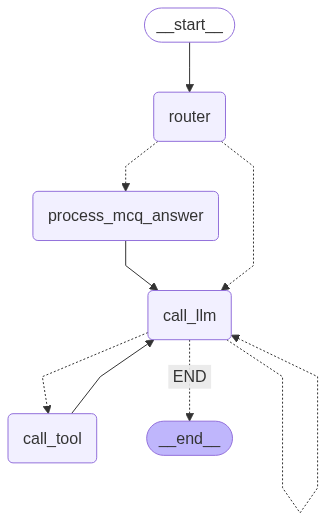

In [ ]:
# Adding Memory to the LangGraph

import os
from typing import List, Dict, TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
import json
import re # Import regex for answer parsing
import time

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# --- 1. Define the Agent State ---
class SocraticAgentState(TypedDict):
    """
    Represents the state of the Socratic tutoring agent.
    
    Attributes:
        messages: A list of BaseMessage objects representing the conversation history.
                  Annotated with add_messages to automatically append new messages.
        difficulty_level: The current difficulty level of the tutoring session (e.g., "beginner", "intermediate").
        user_struggle_count: An integer tracking how many times the user has struggled or answered incorrectly.
        topic: The main Python topic currently being discussed.
        sub_topic: A more specific sub-topic within the main topic.
        mcq_active: A boolean indicating if a Multiple Choice Question is currently active.
        mcq_question: The full text of the active MCQ, including options.
        mcq_options: A list of strings, each representing an option for the active MCQ.
        mcq_correct_answer: The correct answer (e.g., "A", "B", "C", "D") for the active MCQ.
        mcq_explaination: The explaination for the mcq answer
        agent_thought: The internal thought process of the Socratic LLM before generating a response.
        next_node_decision: A string indicating the next node the router should transition to.
                            Used by the supervisor/router to control graph flow.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    mcq_explanation: str 
    agent_thought: str
    next_node_decision: str

memory_saver = MemorySaver()
# --- 2. Initialize the Socratic LLM and Tools ---

# Initialize the main Socratic LLM for general conversation and tool binding.
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", max_retries=3, temperature=0.7)

# Initialize a separate LLM for generating MCQs. This allows for different
# temperature or model settings specifically for MCQ generation.
mcq_generation_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", max_retries=3, temperature=0.5)

# System prompt for the Socratic LLM, guiding its behavior and principles.
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your goal is to guide the user to discover answers
and understand concepts through thoughtful questions, rather than directly providing solutions.

Here are your core principles:
1. **Ask Questions:** Always respond with a question, unless explicitly providing feedback on code or an MCQ answer.
2. **Socratic Method:** Break down complex problems into smaller, manageable questions.
3. **Encourage Exploration:** Prompt the user to experiment, research, or think critically.
4. **Adapt to User Understanding:**
    * **Struggle Detection:** If the user seems confused, provides incorrect answers, or asks for direct solutions, simplify your questions, rephrase, or offer a hint. You can also suggest taking a multiple-choice question (MCQ) to assess their understanding differently.
    * **Progression:** If the user demonstrates understanding, subtly move to a slightly more advanced sub-concept or a related new topic. Avoid repetitive questioning on the same point.
5. **Tool Usage:** You have access to several specialized tools. Use them judiciously based on the user's query:
    * `code_analysis_agent`: Use this when the user provides code and asks for feedback.
    * `code_explanation_agent`: Use this when the user asks for an explanation.
    * `challenge_generator_agent`: Use this when the user wants a coding challenge.
    * `mcq_agent`: Use this only for well-known topics like "variables", "functions", "classes", "conditional statements", "comparisons", or "maximum of three numbers".
    * `llm_mcq_generator`: Use this for all other topics (e.g., "Python decorators", "context managers") or when a custom MCQ is needed.
    * `mcq_answer_processor`: Use this when the user submits an answer to an active MCQ.
6. **Maintain Context:** Keep track of the current topic and sub_topic.
7. **Be Patient and Encouraging:** Foster a positive learning environment.
8. **ReAct Architecture:** Before responding or calling a tool, always articulate your thought process. Start your response with "Thought: [Your reasoning here]". Then, proceed with your question or tool call. If you are calling a tool, the tool call should follow your thought. If you are directly asking a question, the question should follow your thought.
9. **MCQ Answer Format:** When presenting an MCQ, instruct the user to respond with a single letter (A, B, C, or D) to indicate their answer choice.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub_topic: {sub_topic}
User struggle count: {user_struggle_count}
MCQ active: {mcq_active}
MCQ Question (internal): {mcq_question}
MCQ Options (internal): {mcq_options}
MCQ Correct Answer (internal): {mcq_correct_answer}

Begin the conversation by asking the user what Python topic they'd like to learn or practice, or if they'd like to test their knowledge.
"""

# Chat prompt template for the Socratic LLM, including system prompt and message history.
socratic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", socratic_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# --- Define Tools ---
# These tools simulate external functionalities that the Socratic LLM can call.

@tool
def code_analysis_agent(code: str) -> str:
    """
    Analyzes the provided Python code.
    This is a simulated tool. In a real application, it would run static analysis, linters, etc.
    """
    return f"Simulated Code Analysis: Your code snippet '{code}' looks interesting. What were you trying to achieve with this code?"

@tool
def code_explanation_agent(concept: str) -> str:
    """
    Explains a given Python concept.
    This is a simulated tool. In a real application, it would provide detailed explanations.
    """
    return f"Simulated Code Explanation: Ah, you're curious about '{concept}'. Can you tell me what you already know or suspect about it?"

@tool
def challenge_generator_agent(topic: str, difficulty: str) -> str:
    """
    Generates a Python coding challenge based on a topic and difficulty level.
    This is a simulated tool. In a real application, it would generate a specific coding problem.
    """
    return f"Simulated Challenge for '{topic}': 'Write a function that sums even numbers in a list.' How would you start?"

@tool
def mcq_agent(topic: str, difficulty: str) -> str:
    """
    Generates a multiple-choice question (MCQ) on a given Python topic and difficulty level
    from a predefined list. The output will be a JSON string containing the question,
    options, and correct answer. The 'question' field will be pre-formatted to include
    options for direct display.
    This tool is called when the Socratic agent decides to test understanding via MCQ
    and a predefined question is available for the topic.
    """
    mcqs_raw = {
        "variables": {
            "question": "Which of the following data types is mutable in Python?",
            "options": ["A) Tuple", "B) String", "C) List", "D) Integer"],
            "correct_answer": "C"
        },
        "class": {
            "question": "In Python, what is the primary purpose of the `__init__` method in a class?",
            "options": [
                "A) To destroy an object when it's no longer needed.",
                "B) To define static methods.",
                "C) To initialize the attributes of an object when it's created.",
                "D) To define the string representation of an object."
            ],
            "correct_answer": "C"
        },
        "functions": {
            "question": "Which keyword is used to define a function in Python?",
            "options": ["A) func", "B) define", "C) def", "D) function"],
            "correct_answer": "C"
        },
        "conditional statements": {
            "question": "Which Python keyword is used to start an 'if' statement?",
            "options": ["A) then", "B) if", "C) when", "D) check"],
            "correct_answer": "B"
        },
        "comparisons": {
            "question": "What is the correct operator for 'not equal to' in Python?",
            "options": ["A) ==", "B) !=", "C) <>", "D) =!"],
            "correct_answer": "B"
        },
        "maximum of three numbers": {
            "question": "Consider finding the maximum of three numbers (a, b, c). Which of these logical structures is typically used?",
            "options": [
                "A) A single 'for' loop",
                "B) Nested 'if-else' statements or multiple 'if' statements with logical 'and'/'or'",
                "C) A 'while' loop",
                "D) A 'try-except' block"
            ],
            "correct_answer": "B"
        }
    }
    
    # Check if the exact topic exists in our predefined list (case-insensitive)
    selected_mcq_raw = mcqs_raw.get(topic.lower())

    if selected_mcq_raw:
        # Format the question to include options for direct display in chat
        formatted_question = f"**{selected_mcq_raw['question']}**\n\n" + \
                             "\n".join(selected_mcq_raw['options'])

        mcq_data = {
            "question": formatted_question,
            "options": selected_mcq_raw['options'],
            "correct_answer": selected_mcq_raw['correct_answer']
        }
        return json.dumps(mcq_data)
    else:
        # If topic not found, return a special string to indicate that the LLM should
        # consider using the `llm_mcq_generator` tool instead.
        return "NO_PREDEFINED_MCQ_FOUND"


@tool
def llm_mcq_generator(topic: str, difficulty: str) -> dict:
    """
    Generates an MCQ using an LLM based on a topic and difficulty level.
    """
    prompt = f"""
You are an expert Python tutor who generates multiple choice questions (MCQs) for practice.
Generate an MCQ on the topic "{topic}" at a "{difficulty}" level.

The MCQ must follow this format strictly as a JSON object:
{{
    "question": "string",
    "options": ["Option A", "Option B", "Option C", "Option D"],
    "answer_index": 1,
    "explanation": "string"
}}

For questions involving code snippets, format the code within triple backticks (```) to preserve readability, and ensure all strings are JSON-compatible (newlines escaped as \\n).
DO NOT include outer markdown code fences like ```json or ```python
Respond with raw valid JSON only. No extra text.
"""

    llm_response = llm.invoke([HumanMessage(content=prompt)])
    raw_llm_content = llm_response.content.strip()
    print("[DEBUG] Raw LLM MCQ Response:", repr(raw_llm_content))

    # Strip outer markdown fences
    cleaned_content = re.sub(r'^```(json|python)?\n?', '', raw_llm_content, flags=re.MULTILINE)
    cleaned_content = re.sub(r'\n?```$', '', cleaned_content, flags=re.MULTILINE)
    
    # Replace problematic characters, but preserve code formatting
    cleaned_content = (
        cleaned_content
        .replace('“', '"').replace('”', '"')  # Replace smart quotes
        .replace('‘', "'").replace('’', "'")  # Replace smart single quotes
        .replace('\u201c', '"').replace('\u201d', '"')  # Replace Unicode quotes
        .replace('\u2018', "'").replace('\u2019', "'")  # Replace Unicode single quotes
        .replace('\t', '    ')  # Replace tabs with spaces for code readability
    )

    print("[DEBUG] Cleaned LLM MCQ Response:", repr(cleaned_content))

    try:
        mcq_data = json.loads(cleaned_content)
        # Validate JSON structure
        required_keys = {"question", "options", "answer_index", "explanation"}
        if not all(key in mcq_data for key in required_keys):
            raise ValueError("Invalid MCQ format: Missing required keys")
        if not isinstance(mcq_data["options"], list) or len(mcq_data["options"]) != 4:
            raise ValueError("Invalid MCQ format: Options must be a list of 4 strings")
        if not isinstance(mcq_data["answer_index"], int) or mcq_data["answer_index"] not in [0, 1, 2, 3]:
            raise ValueError("Invalid MCQ format: answer_index must be an integer between 0 and 3")
        
        # Format question for display with options
        formatted_question = f"**{mcq_data['question']}**\n\n" + "\n".join(mcq_data["options"])
        mcq_data["question"] = formatted_question
        return mcq_data
    except (json.JSONDecodeError, ValueError) as e:
        print("[ERROR] JSON parsing or validation failed:", str(e))
        print("[ERROR] Cleaned content:", repr(cleaned_content))
        default_mcq = {
            "question": "**What is a Python decorator?**\n\n" + 
                        "\n".join([
                            "A) A function that modifies another function or method",
                            "B) A type of class inheritance",
                            "C) A syntax for defining variables",
                            "D) A loop construct"
                        ]),
            "options": [
                "A) A function that modifies another function or method",
                "B) A type of class inheritance",
                "C) A syntax for defining variables",
                "D) A loop construct"
            ],
            "answer_index": 0,
            "explanation": "A Python decorator is a function that wraps another function or method to extend or modify its behavior."
        }
        return {"error": f"Failed to parse or validate MCQ JSON: {str(e)}", **default_mcq}

@tool
def mcq_answer_processor(user_answer: str, correct_answer: str, explanation: str = "") -> str:
    """
    Processes the user's answer to an MCQ.
    Compares the user's answer with the correct answer and returns feedback with explanation.
    """
    is_correct = user_answer.strip().upper() == correct_answer.strip().upper()
    if is_correct:
        return f"Correct!\n\nExplanation: {explanation}"
    else:
        return f"Incorrect.\n\nExplanation: {explanation}"


# List of all tools available to the Socratic LLM
tools = [code_analysis_agent, code_explanation_agent, challenge_generator_agent, mcq_agent, llm_mcq_generator, mcq_answer_processor]
# Bind the tools to the main Socratic LLM, allowing it to call them.
llm_with_tools = llm.bind_tools(tools, tool_choice="auto")
# Combine the prompt and the LLM with tools into a runnable for the Socratic agent.
socratic_agent_runnable = socratic_prompt | llm_with_tools

# --- 3. Define the Graph Nodes ---

def call_llm(state: SocraticAgentState):
    """
    Invokes the Socratic LLM with the current conversation history and state.
    This node represents the core logic of the Socratic tutoring agent.
    It extracts the LLM's "thought" and formats the content for display.
    """
    print("[DEBUG] Entering call_llm node.")
    print("[DEBUG] Messages sent to LLM:", state["messages"])
    
    try:
        response = socratic_agent_runnable.invoke({
            "messages": state["messages"],
            **{k: v for k, v in state.items() if k not in ['messages', 'next_node_decision']}
        })
        print("[DEBUG] LLM Response:", response)
        
        content = response.content
        if isinstance(content, list):
            content = "\n".join(str(item) for item in content)
        elif not isinstance(content, str):
            print("[ERROR] Unexpected content type:", type(content))
            content = ""

        thought = ""
        display_content = ""
        if content and content.startswith("Thought:"):
            parts = content.split("Thought:", 1)
            thought_and_content = parts[1].strip()
            thought_lines = thought_and_content.split('\n', 1)
            thought = thought_lines[0].strip()
            display_content = thought_lines[1].strip() if len(thought_lines) > 1 else ""
        else:
            display_content = content

        new_ai_message = AIMessage(
            content=display_content,
            tool_calls=response.tool_calls
        )

        return {"messages": [new_ai_message], "agent_thought": thought}
    except Exception as e:
        print(f"[ERROR] LLM invocation failed", str(e))

# A dictionary mapping tool names to their corresponding Python functions.
TOOLS_USED = {
    "code_analysis_agent": code_analysis_agent,
    "code_explanation_agent": code_explanation_agent,
    "challenge_generator_agent": challenge_generator_agent,
    "mcq_agent": mcq_agent,
    "llm_mcq_generator": llm_mcq_generator,
    "mcq_answer_processor": mcq_answer_processor,
}

def call_tool(state: SocraticAgentState):
    print("[DEBUG] Entering call_tool node.")
    last_message = state["messages"][-1]
    messages_to_add = []
    state_updates = {}

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            tool_function = TOOLS_USED.get(tool_name)
            
            if tool_function:
                response = tool_function.invoke(tool_args)
                tool_output_content = str(response)

                existing_tool_message = any(
                    isinstance(msg, ToolMessage) and msg.tool_call_id == tool_call["id"]
                    for msg in state["messages"]
                )
                
                if not existing_tool_message:
                    messages_to_add.append(
                        ToolMessage(content=tool_output_content, tool_call_id=tool_call["id"])
                    )

                if tool_name in ["mcq_agent", "llm_mcq_generator"]:
                    if tool_output_content == "NO_PREDEFINED_MCQ_FOUND":
                        messages_to_add.append(
                            AIMessage(content="No predefined MCQ found for this topic. Generating a new one...")
                        )
                        continue
                    
                    try:
                        mcq_data = json.loads(tool_output_content) if isinstance(response, str) else response
                        if "error" in mcq_data:
                            formatted_question = f"{mcq_data['question']}\n\nOptions:\n" + "\n".join(
                                f"{chr(65 + i)}. {opt}" for i, opt in enumerate(mcq_data.get("options", []))
                            ) + "\n\nPlease select an option (A, B, C, or D)."
                            messages_to_add.append(
                                AIMessage(content=formatted_question)
                            )
                            state_updates["mcq_active"] = True
                            state_updates["mcq_question"] = mcq_data.get("question", "").split("```")[0].strip()  # Store only question text
                            state_updates["mcq_options"] = mcq_data.get("options", [])
                            answer_index = mcq_data.get("answer_index")
                            correct_answer = chr(65 + answer_index) if isinstance(answer_index, int) and 0 <= answer_index <= 3 else ""
                            state_updates["mcq_correct_answer"] = correct_answer
                            state_updates["mcq_explanation"] = mcq_data.get("explanation", "")
                            if not state.get("topic") and tool_args.get("topic"):
                                state_updates["topic"] = tool_args["topic"]
                        else:
                            formatted_question = f"{mcq_data['question']}\n\nOptions:\n" + "\n".join(
                                f"{chr(65 + i)}. {opt}" for i, opt in enumerate(mcq_data.get("options", []))
                            ) + "\n\nPlease select an option (A, B, C, or D)."
                            messages_to_add.append(
                                AIMessage(content=formatted_question)
                            )
                            state_updates["mcq_active"] = True
                            state_updates["mcq_question"] = mcq_data.get("question", "").split("```")[0].strip()  # Store only question text
                            state_updates["mcq_options"] = mcq_data.get("options", [])
                            answer_index = mcq_data.get("answer_index")
                            correct_answer = chr(65 + answer_index) if isinstance(answer_index, int) and 0 <= answer_index <= 3 else ""
                            state_updates["mcq_correct_answer"] = correct_answer
                            state_updates["mcq_explanation"] = mcq_data.get("explanation", "")
                            if not state.get("topic") and tool_args.get("topic"):
                                state_updates["topic"] = tool_args["topic"]
                    except json.JSONDecodeError:
                        messages_to_add.append(
                            AIMessage(content="Error: MCQ agent returned invalid JSON. Please try again.")
                        )
                        continue
                elif tool_name == "mcq_answer_processor":
                    if "Correct!" in tool_output_content:
                        state_updates["user_struggle_count"] = 0
                    else:
                        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
                    state_updates["mcq_active"] = False
                    state_updates["mcq_question"] = ""
                    state_updates["mcq_options"] = []
                    state_updates["mcq_correct_answer"] = ""
                    state_updates["mcq_explanation"] = ""
            else:
                messages_to_add.append(
                    ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_call["id"])
                )
    print(f"[DEBUG] call_tool: State updates - {state_updates}")
    return {"messages": messages_to_add, **state_updates}


def router(state: SocraticAgentState):
    """
    The supervisor node that decides the next action based on the current state and user input.
    It primarily routes between processing an MCQ answer directly or letting the Socratic LLM respond.
    
    Returns a dictionary containing 'next_node_decision' to control graph flow.
    """
    print("[DEBUG] Entering router node.")
    last_message = state["messages"][-1]
    
    next_decision = ""
    if state.get("mcq_active", False) and isinstance(last_message, HumanMessage):
        user_input = last_message.content.strip().upper()
        if re.match(r"^[ABCD](\.|\))?$", user_input):
            print("[DEBUG] Router: Detected MCQ answer, routing to process_mcq_answer.")
            next_decision = "process_mcq_answer"
        else:
            print("[DEBUG] Router: MCQ active but invalid answer, prompting for valid input.")
            return {
                "next_node_decision": "call_llm",
                "messages": [AIMessage(content="Please respond with a single letter (A, B, C, or D) to select your answer.")]
            }
    else:
        print("[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).")
        next_decision = "call_llm"
    
    return {"next_node_decision": next_decision}

def process_mcq_answer(state: SocraticAgentState):
    print("[DEBUG] Entering process_mcq_answer node.")
    last_human_message = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_human_message = msg
            break
    
    if not last_human_message:
        print("[ERROR] process_mcq_answer: Could not find a HumanMessage to process.")
        return {"messages": []}

    user_answer = last_human_message.content.strip().upper()
    correct_answer = state.get("mcq_correct_answer", "")
    explanation = state.get("mcq_explanation", "No explanation available.")
    
    tool_output_content = mcq_answer_processor.invoke({
        "user_answer": user_answer,
        "correct_answer": correct_answer,
        "explanation": explanation
    })
    
    state_updates = {}
    messages_to_add = []

    if "Correct!" in tool_output_content:
        state_updates["user_struggle_count"] = 0
    else:
        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
    
    state_updates["mcq_active"] = False
    state_updates["mcq_question"] = ""
    state_updates["mcq_options"] = []
    state_updates["mcq_correct_answer"] = ""
    state_updates["mcq_explanation"] = ""

    messages_to_add.append(
        ToolMessage(content=tool_output_content, tool_call_id="mcq_processor_direct_call")
    )
    messages_to_add.append(
        AIMessage(content=f"You answered: {user_answer}. The correct answer was {correct_answer}. {tool_output_content}")
    )

    print(f"[DEBUG] process_mcq_answer: Result - {tool_output_content}, New struggle count: {state_updates.get('user_struggle_count')}")
    return {"messages": messages_to_add, **state_updates}

# --- 4. Define the Graph Edges ---

def should_continue_socratic(state: SocraticAgentState):
    print("[DEBUG] Entering should_continue_socratic edge logic.")
    last_message = state["messages"][-1]
    
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("[DEBUG] should_continue_socratic: Socratic agent has tool calls, routing to call_tool.")
        return "call_tool"
    elif state.get("mcq_active", False) and isinstance(last_message, AIMessage) and "Please select an option (A, B, C, or D)" in last_message.content:
        print("[DEBUG] should_continue_socratic: MCQ presented, waiting for user answer.")
        return "END"
    elif isinstance(last_message, AIMessage) and "An issue occurred" in last_message.content:
        print("[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.")
        return "END"
    else:
        print("[DEBUG] should_continue_socratic: Routing to call_llm for further interaction.")
        return "call_llm"

# --- 5. Build the LangGraph ---

# Initialize the StateGraph with our defined state.
workflow = StateGraph(SocraticAgentState)

# Add all the nodes to the workflow.
workflow.add_node("router", router) # The new supervisor node.
workflow.add_node("call_llm", call_llm) # The Socratic agent's LLM logic.
workflow.add_node("call_tool", call_tool) # The tool execution logic.
workflow.add_node("process_mcq_answer", process_mcq_answer) # Node for direct MCQ answer processing.

# Set the `router` node as the starting point of the graph.
workflow.set_entry_point("router")

# Define conditional edges from the `router` node.
# The `router` function itself determines the next node based on the state.
workflow.add_conditional_edges(
    "router",
    lambda state: state["next_node_decision"], # Use the decision stored in state by the router function.
    {
        "call_llm": "call_llm",         # If router decides, go to the Socratic LLM.
        "process_mcq_answer": "process_mcq_answer" # If router detects MCQ answer, go to process it.
    }
)

# Define conditional edges from the `call_llm` node (Socratic agent's LLM).
# `should_continue_socratic` determines if a tool needs to be called or if the turn ends.
workflow.add_conditional_edges(
    "call_llm",
    should_continue_socratic,
    {"call_tool": "call_tool", "END": END, "call_llm": "call_llm"} # If tool calls, go to `call_tool`; otherwise, end.
)

# Define a regular edge from `call_tool` back to `call_llm`.
# After a tool is executed, the Socratic LLM needs to process the tool's output and generate a response.
workflow.add_edge("call_tool", "call_llm")

# Define a regular edge from `process_mcq_answer` back to `call_llm`.
# After an MCQ answer is processed, the Socratic LLM needs to provide feedback and potentially a new question.
workflow.add_edge("process_mcq_answer", "call_llm")

# Compile the workflow into a runnable graph.
socratic_graph = workflow.compile(checkpointer=memory_saver)

# Example test for the new LLM-generated MCQ
thread_id = "user_session_123"
print("\n--- Testing LLM-generated MCQ for an unknown topic (decorators) ---")
llm_mcq_state = {
    "messages": [HumanMessage(content="Can you give me an MCQ on Python decorators?")],
    "difficulty_level": "intermediate",
    "user_struggle_count": 0,
    "topic": "",
    "sub_topic": "",
    "mcq_active": False,
    "mcq_question": "",
    "mcq_options": [],
    "mcq_correct_answer": "",
    "mcq_explanation": "",
    "agent_thought": "",
    "next_node_decision": ""
}

# Invoke the graph with the thread_id to persist state
result = socratic_graph.invoke(llm_mcq_state, config={"configurable": {"thread_id": thread_id}})
import pprint
pprint.pprint(result)

In [5]:

# Example test for the new LLM-generated MCQ
thread_id = "user_session_123"
print("\n--- Testing LLM-generated MCQ for an unknown topic (decorators) ---")
llm_mcq_state = {
    "messages": [HumanMessage(content="Can you give me an MCQ on Python decorators?")],
    "difficulty_level": "intermediate",
    "user_struggle_count": 0,
    "topic": "",
    "sub_topic": "",
    "mcq_active": False,
    "mcq_question": "",
    "mcq_options": [],
    "mcq_correct_answer": "",
    "mcq_explanation": "",
    "agent_thought": "",
    "next_node_decision": ""
}

# Invoke the graph with the thread_id to persist state
result = socratic_graph.invoke(llm_mcq_state, config={"configurable": {"thread_id": thread_id}})
import pprint
pprint.pprint(result)

# # Simulate a follow-up interaction to demonstrate memory
# follow_up_state = {
#     "messages": [HumanMessage(content="B")],  # User responds to the MCQ
#     "difficulty_level": result["difficulty_level"],
#     "user_struggle_count": result["user_struggle_count"],
#     "topic": result["topic"],
#     "sub_topic": result["sub_topic"],
#     "mcq_active": result["mcq_active"],
#     "mcq_question": result["mcq_question"],
#     "mcq_options": result["mcq_options"],
#     "mcq_correct_answer": result["mcq_correct_answer"],
#     "mcq_explanation": result["mcq_explanation"],
#     "agent_thought": result["agent_thought"],
#     "next_node_decision": ""
# }

# # Invoke the graph again with the same thread_id to retrieve the previous state
# result_follow_up = socratic_graph.invoke(follow_up_state, config={"configurable": {"thread_id": thread_id}})
# pprint.pprint(result_follow_up)


--- Testing LLM-generated MCQ for an unknown topic (decorators) ---
[DEBUG] Entering router node.
[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).
[DEBUG] Entering call_llm node.
[DEBUG] Messages sent to LLM: [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='75c0607f-9423-49c1-88ff-e7b48cac15e3')]
[DEBUG] LLM Response: content='' additional_kwargs={'function_call': {'name': 'llm_mcq_generator', 'arguments': '{"topic": "Python decorators", "difficulty": "intermediate"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--07d1f8b7-d6c4-4cfd-b268-cbbe4c534136-0' tool_calls=[{'name': 'llm_mcq_generator', 'args': {'topic': 'Python decorators', 'difficulty': 'intermediate'}, 'id': '2fe15ace-05f1-49bc-8728-5957249c2576', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1139, 'outpu

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
[DEBUG] Entering should_continue_socratic edge logic.
[DEBUG] should_continue_socratic: MCQ presented, waiting for user answer.
{'agent_thought': '',
 'difficulty_level': 'intermediate',
 'mcq_active': True,
 'mcq_correct_answer': 'B',
 'mcq_explanation': 'When you use a decorator without `functools.wraps`, the '
                    'decorated function is replaced by the wrapper function '
                    'returned by the decorator. This means that introspection '
                    'tools (like `help()` or accessing attributes like '
                    '`__name__` or `__doc__`) would report details of the '
                    'wrapper function, not the original function. '
                    '`functools.wraps` is a decorator itself that copies the '
                    'name, docstring, module, and other attributes from the '
